# FORECASTING WITH SARIMA MODEL





The problem with plain ARIMA model is it does not support seasonality.
In this hourly average dataset we could see seasonality pattern, therefore, we proceed with SARIMA model which uses seasonal differencing. Seasonal differencing is just similar to regular differencing, but, instead of subtracting successive terms, we subtract the value from previous season.

ARIMA model includes three main parameters as p, d and q.

p: The order of the autoregressive model.

q: The order of the moving average model.

d: The number of differences required to make the time series stationary.

The SARIMA model builds upon the ARIMA model. It also includes the p, q, and d parameters, but also an extra set of parameters to account for time series seasonality.

P: The order of the seasonal autoregressive model.

Q: The order of the seasonal moving average model.

D: The number of seasonal differences applied to the time series.

Therefore we can denote the notation of the SARIMA model as SARIMA(p,d,q)(P,D,Q,s). Here s denotes the seasonality of the year.

In [1]:
#General libraries
##################

import pandas as pd
import numpy as np
from numpy import mean


#Plotting libraries
##################

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sbn
from pandas.plotting import autocorrelation_plot
from pandas import Series
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

#Libraries/functions for General Modelling, metrics, etc..
###############################################


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

#Libraries/functions for Modelling ARIMA
#######################################

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
import statsmodels.api as sm


#Other Support Libraries/functions
#################################

import warnings
import itertools
import datetime
import pickle
from math import sqrt

warnings.filterwarnings("ignore")

In [2]:
#Opening dataframe with AirStation 16 data
########################################

poc_16 = pd.read_csv ("../data/processed/poc_16.csv", sep= ',')
poc_16.index = poc_16.TIME
poc_16 = poc_16[["NO2_index"]]
poc_16.tail()

,NO2_index
TIME,
2021-08-31 19:59:59,12.0
2021-08-31 20:59:59,16.0
2021-08-31 21:59:59,59.0
2021-08-31 22:59:59,11.0
2021-08-31 23:59:59,8.0


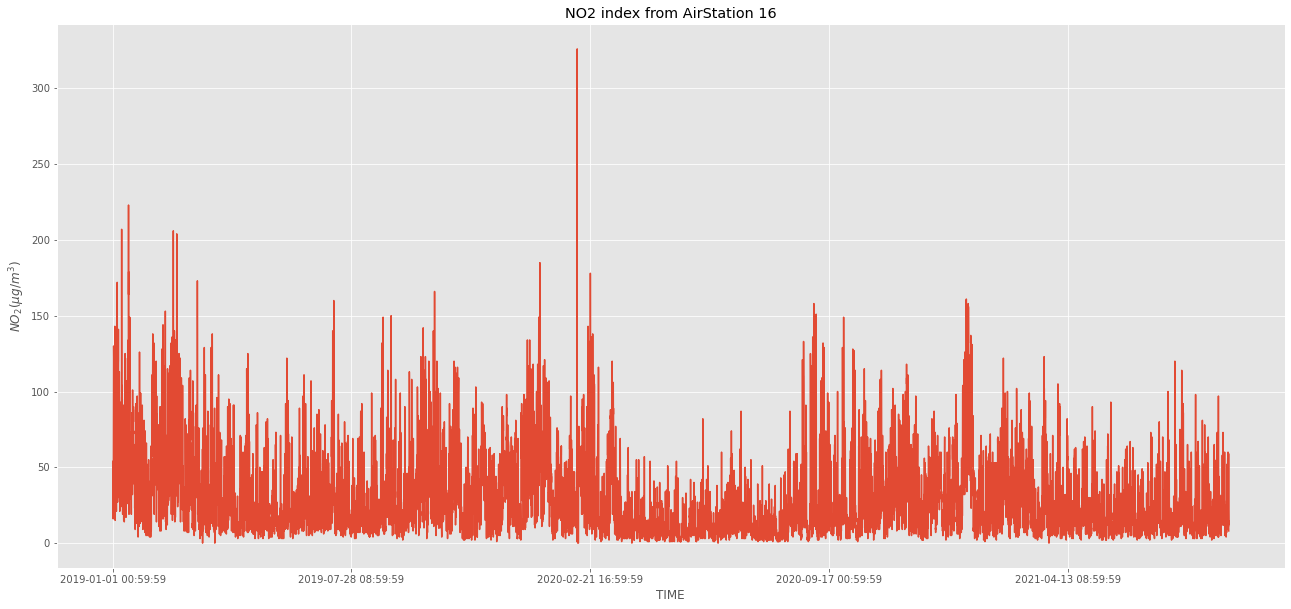

count    23376.000000
mean        28.315495
std         25.121162
min          0.000000
25%         11.000000
50%         20.000000
75%         38.000000
max        326.000000
dtype: float64


In [3]:
#plotting the data
##################

series = Series(poc_16["NO2_index"].values,index=poc_16.index)
series.plot(figsize=(22,10))
plt.title('NO2 index from AirStation 16')
plt.ylabel("$NO_2 (µg/m^3)$", fontsize=12)
plt.show()
print(series.describe());

**Test Dickey-Fuller**

To identify the nature of data, we will be using the null hypothesis.

H0: The null hypothesis: It is a statement about the population that either is believed to be true or is used to put forth an argument unless it can be shown to be incorrect beyond a reasonable doubt.

H1: The alternative hypothesis: It is a claim about the population that is contradictory to H0 and what we conclude when we reject H0.

H0: It is non-stationary

H1: It is stationary

We will be considering the null hypothesis that data is not stationary and the alternate hypothesis that data is stationary.

In [4]:
# Test Dickey-Fuller
####################

result=adfuller(poc_16['NO2_index'])

def adfuller_test(NO2_index):
    result = adfuller(NO2_index)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

if result[1] <= 0.05:
    print("Strong evidence against the null hypothesis(HO), reject the null hypothesis. Data is stationary")
else:
    print("Weak evidence against null hypothesis. Data is non-stationary ")

adfuller_test(poc_16['NO2_index'])

Strong evidence against the null hypothesis(HO), reject the null hypothesis. Data is stationary
ADF Test Statistic : -9.656699472912415
p-value : 1.3879931518790027e-16
#Lags Used : 47
Number of Observations : 23328


**How we select suitable parameter combination to fit to SARIMA model ?**

Selecting the best ARIMA model configuration is usually an iterative process. For that, we can use a “grid search” to iteratively explore different combinations of parameters.

For each combination of parameters, we fit a new seasonal SARIMA model with the SARIMAX() function from the statsmodels module and calculate the AIC (Akaike information criterion). 
The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies the goodness of fit, and the simplicity/parsimony, of the model into a single statistic.
AIC is used to measure the relative quality of the statsmodels.

In [5]:
# Define the d and q parameters to take any value between 0 and 1
#################################################################
q = d = range(0, 2)

# Define the p parameters to take any value between 0 and 3. 
#It is defining how many data points back will be used for prediction
#####################################################################
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
############################################################
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q , keeping 12 Even with the first order of differencing, 
#we observe that there is still slow residual decay in the ACF plots at a seasonal lag period of 12. 
# This thus suggest a seasonal difference to be applied.

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Observations: 23376
Training Observations: 13848
Testing Observations: 9480


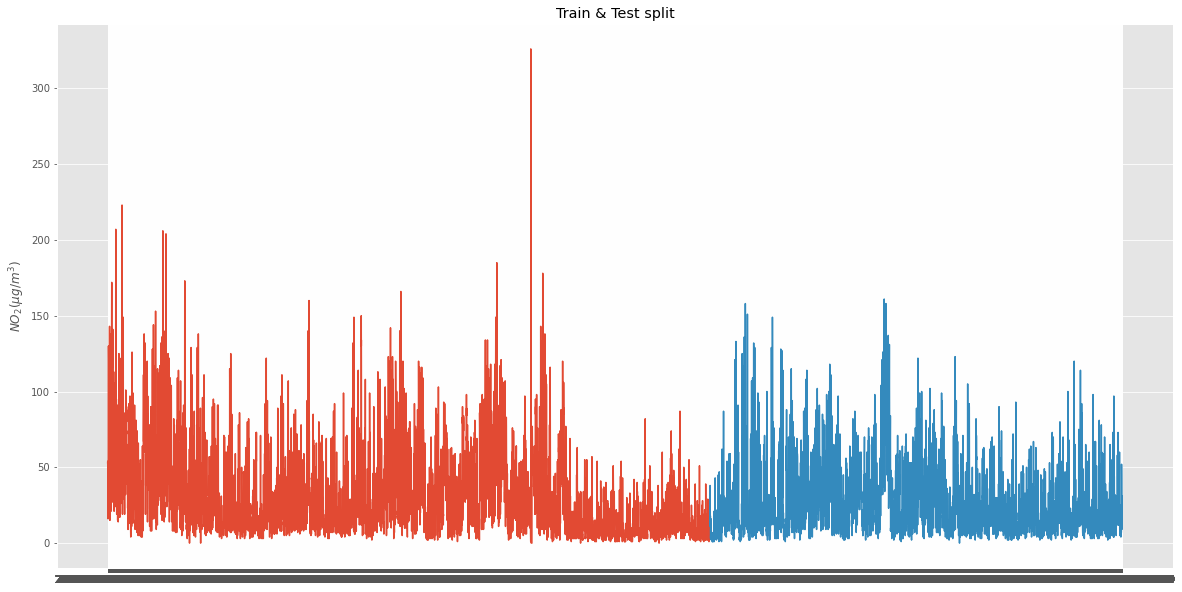

In [7]:
#Splitting train and test dataset
#################################

train_data = poc_16['2019-01-01':'2020-07-31']
test_data = poc_16['2020-08-01':'2021-08-31']

print('Observations: %d' % (len(poc_16)))
print('Training Observations: %d' % (len(train_data)))
print('Testing Observations: %d' % (len(test_data)))

plt.title("Train & Test split")
plt.ylabel("$NO_2 (µg/m^3)$", fontsize=12)
plt.plot(train_data)
plt.plot(test_data)
plt.show()

Below is the code for automatic selection of the best parameters to be used for the ARIMA model

In [7]:
#Selecting the best combination to fit SARIMA
##############################################


AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [8]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 103712.37525338921 for model SARIMAX(3, 0, 1)x(3, 1, 1, 12)


Based on previous parameters identfied automatically based on the lowest AIC, now ARIMA model is created.

In [9]:
# Fitting the model auto-selecting the best combination
#######################################################

mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

**Note:** As the automatic parameter selection for the model (above code lines) is taken a while (several hours), below it is the code for manual ARIMA model creation just for testing propuses without the need to run automatic parameter selection script.

In [8]:
# Fitting the model manually selecting the best combination 3,0,1 x 3,1,1,12 - AIC 103712.375
############################################################################################


mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=(3,0,1),
                                seasonal_order=(3,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

Model summary results:

In [9]:
# Model summary
###############

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          NO2_index   No. Observations:                13848
Model:             SARIMAX(3, 0, 1)x(3, 1, 1, 12)   Log Likelihood              -51847.188
Date:                            Mon, 17 Jan 2022   AIC                         103712.375
Time:                                    20:17:24   BIC                         103780.165
Sample:                                01-01-2019   HQIC                        103734.959
                                     - 07-30-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9171      0.008    244.514      0.000       1.902       1.932
ar.L2         -1.0766      0.008   

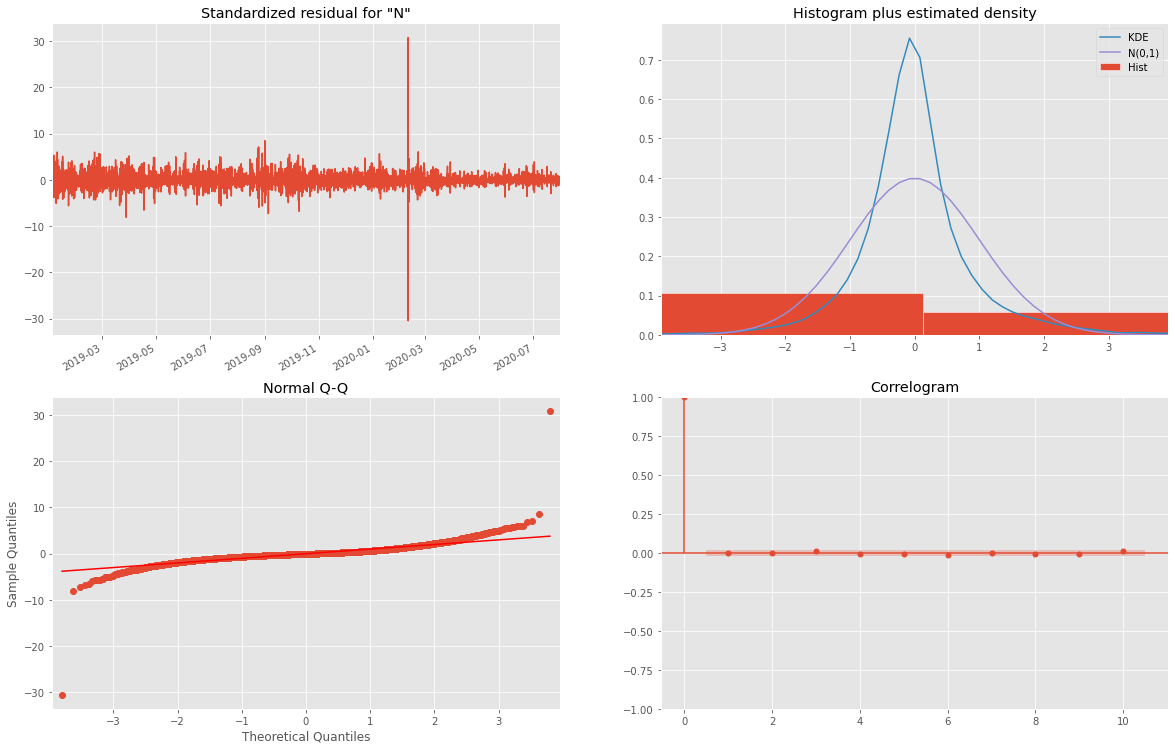

In [11]:
#Plotting diagnostics graphs to evaluate the model result
#########################################################

results.plot_diagnostics(figsize=(20, 14))
plt.show()

**DIAGNOSTICs PLOT ANALYSIS**

STANDARDIZED RESIDUAL: Uniform variance around mean of 0.

HISTOGRAM ESTIMATED DENSITY: Distribution looks like to be Normal Distribution (with mean 0)

NORMAL Q-Q: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

CORRELOGRAM: Plot show that residual errors are not autocorrelated. In case of autocorrelation would mean that there is some pattern in the residual errors which are not explained in this model.

Overall, it seems to be a good fit. Let’s forecast

**Saving the model**

To save the model all we need to do is pass the model object into the dump() function of Pickle. 
This will serialize the object and convert it into a “byte stream” that we can save as a file called xx.pkl.

In [9]:
# Saving the model
##################

######pickle.dump(results, open('../models/poc_16_SARIMAmodel_301_311_12.pkl', 'wb'))


## Non - Dynamic Forecasting (Static)



This method produce one-step-ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.


In [10]:
modelB = sm.tsa.SARIMAX(test_data, order=(3,0,1),
                                seasonal_order=(3,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
resB = modelB.smooth(results.params)

Next, we want to get results for the full dataset but using the estimated parameters (on a subset of the data).

In [11]:
test_data

,NO2_index
TIME,
2020-08-01 00:59:59,23.0
2020-08-01 01:59:59,16.0
2020-08-01 02:59:59,20.0
2020-08-01 03:59:59,24.0
2020-08-01 04:59:59,38.0
...,...
2021-08-30 19:59:59,17.0
2021-08-30 20:59:59,25.0
2021-08-30 21:59:59,28.0


In [31]:
pred = resB.get_prediction( dynamic=False)
pred_ci = pred.conf_int()
pred_ci[8000:]

,lower NO2_index,upper NO2_index
2021-06-30 08:59:59,20.460327,61.167493
2021-06-30 09:59:59,10.573270,51.280436
2021-06-30 10:59:59,7.747377,48.454544
2021-06-30 11:59:59,6.499643,47.206809
2021-06-30 12:59:59,10.715694,51.422860
...,...,...
2021-08-30 19:59:59,1.440084,42.147250
2021-08-30 20:59:59,1.242744,41.949910
2021-08-30 21:59:59,5.760872,46.468038
2021-08-30 22:59:59,7.174409,47.881575


In [ ]:
tst=pred_ci

tst['MOE'] = tst[upper NO2_index]-tst[lower NO2_index]

<AxesSubplot:>

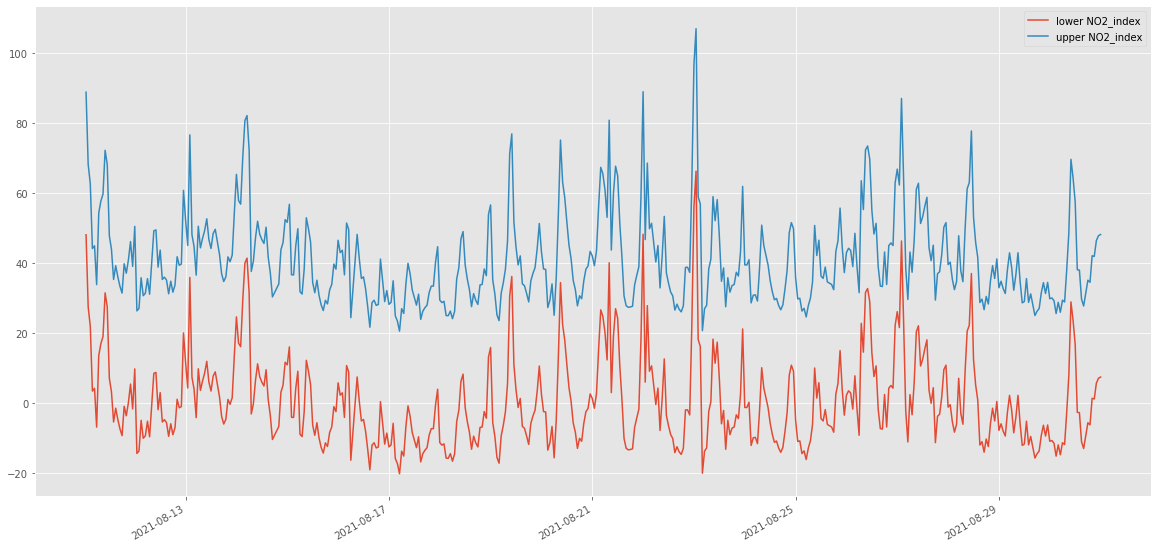

In [35]:
pred_ci[9000:].plot()


In [36]:
#NonDynamic forecasting - one step ahead
########################################


test_data['forecast_1_step'] = resB.predict(dynamic=False)


In [37]:
test_data.tail()


,NO2_index,forecast_1_step
TIME,,
2021-08-30 19:59:59,17.0,21.793667
2021-08-30 20:59:59,25.0,21.596327
2021-08-30 21:59:59,28.0,26.114455
2021-08-30 22:59:59,31.0,27.527992
2021-08-30 23:59:59,22.0,27.863342


In [38]:
df_inner = test_data.merge(pred_ci, how='inner', left_index=True, right_index=True)

<AxesSubplot:>

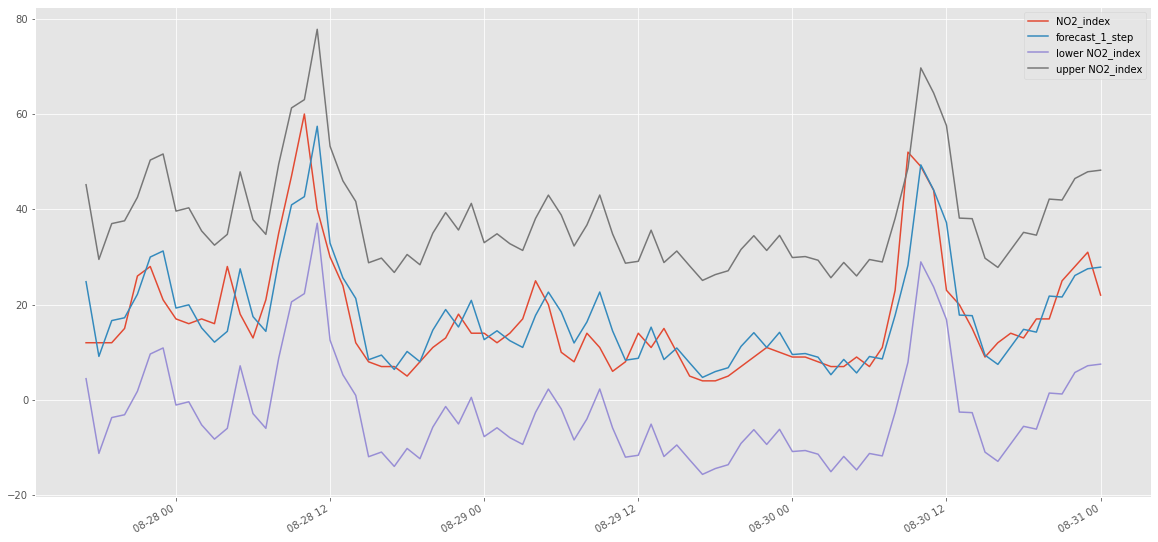

In [41]:
df_inner[9400:].plot()

In [ ]:
fig, ax = plt.subplots()
ax.plot(df_inner[TIME],df_inner[forecast_1_step])
ax.fill_between(df_inner[TIME], (y-ci), (y+ci), color='b', alpha=.1)

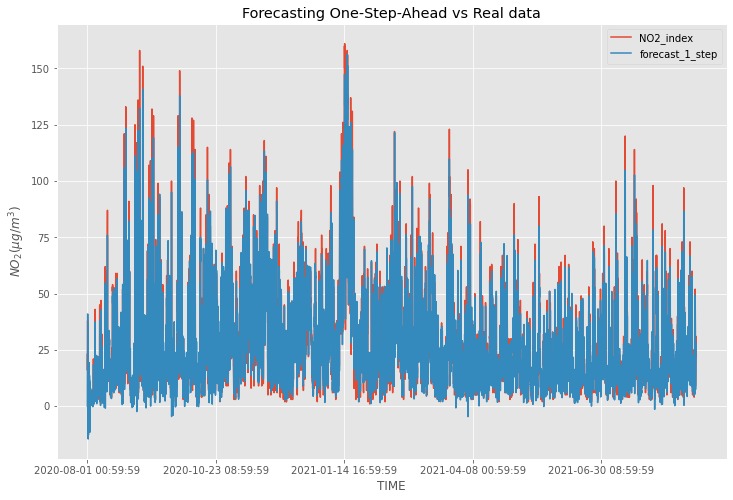

In [16]:
#Plotting forecast_1_step ahead vs real data
############################################


test_data[['NO2_index', 'forecast_1_step']].plot(figsize=(12, 8))
plt.ylabel("$NO_2 (µg/m^3)$", fontsize=12)
plt.title("Forecasting One-Step-Ahead vs Real data");

### EVALUATING THE MODEL

The **Mean absolute error** represents the average of the absolute difference between the actual and predicted values in the dataset. It measures the average of the residuals in the dataset.

The **Mean Squared Error** represents the average of the squared difference between the original and predicted values in the data set. It measures the variance of the residuals.

The **Root Mean Squared Error** is the square root of Mean Squared error. It measures the standard deviation of residuals.


Differences among these evaluation metrics

Mean Squared Error(MSE) and Root Mean Square Error penalizes the large prediction errors vi-a-vis Mean Absolute Error (MAE). However, RMSE is widely used than MSE to evaluate the performance of the regression model with other random models as it has the same units as the dependent variable (Y-axis).

MSE is a differentiable function that makes it easy to perform mathematical operations in comparison to a non-differentiable function like MAE. Therefore, in many models, RMSE is used as a default metric for calculating Loss Function despite being harder to interpret than MAE.

MAE is more robust to data with outliers.

The lower value of MAE, MSE, and RMSE implies higher accuracy of a regression model. However, a higher value of R square is considered desirable.




In [17]:
#Evaluating the model
#####################

mea = mean_absolute_error(test_data.NO2_index, test_data.forecast_1_step)
mae =mean_squared_error(test_data.NO2_index, test_data.forecast_1_step)
rmse = sqrt(mean_squared_error(test_data.NO2_index, test_data.forecast_1_step))

print("Mean Square Error: ",mea)
print("Mean Absolute Error: ",mae)
print("Root Mean Squared Error: ",rmse)

Mean Square Error:  5.802793460464004
Mean Absolute Error:  78.66918938091067
Root Mean Squared Error:  8.86956534340385




  Prediction Models | MSE | MAE | RMSE
:--------: | ------- | ------- | ------- 
Static forecasting: one-step-ahead|5.8 | 78.6 | 8.8 | 


## Dynamic Forecasting - 24 hours window


By the dynamic forecasting we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points. This method allow calculate different time windows

In [ ]:
#Splitting train and test dataset
#################################

train_data = poc_16['2019-01-01':'2020-07-31']
test_data = poc_16['2020-08-01':'2021-08-31']

#concatenating train and test
#############################

data = pd.concat([train_data, test_data])[['NO2_index']]

#Running the model
##################

modelB = sm.tsa.SARIMAX(data, order=(3,0,1),
                                seasonal_order=(3,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
resB = modelB.smooth(results.params)

#Predicting 24 hours window
###########################

forecast = [np.NaN]*len(data)
for i in range(len(train_data), len(data)-25):
    pred = resB.predict(start = i, end=i+24, dynamic=True)
    forecast[i+24] = pred.iloc[24]
    pred2=resB.get_prediction(dynamic=True)
    pred2_ci = pred2.conf_int()
data['forecast_24'] = forecast
data




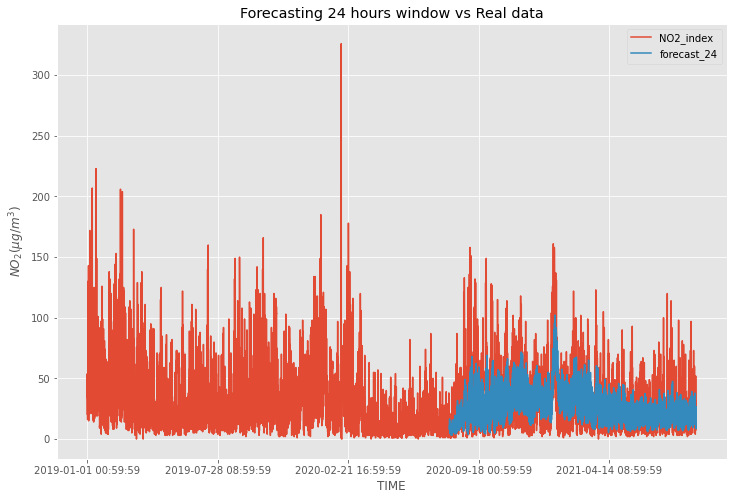

In [19]:
#Plotting 24hours prediction window vs real data
################################################

data[['NO2_index', 'forecast_24']].plot(figsize=(12, 8))

plt.ylabel("$NO_2 (µg/m^3)$", fontsize=12)
plt.title("Forecasting 24 hours window vs Real data");

In [20]:
#Evaluating the 24 hour window dynamic forecasting model
########################################################

data = data.dropna()

mea = mean_absolute_error(data.NO2_index, data.forecast_24)
mae = mean_squared_error(data.NO2_index, data.forecast_24)
rmse = sqrt(mean_squared_error(data.NO2_index, data.forecast_24))

print("Mean Square Error: ",mea)
print("Mean Absolute Error: ",mae)
print("Root Mean Squared Error: ",rmse)

Mean Square Error:  13.300817658548352
Mean Absolute Error:  340.8621112998259
Root Mean Squared Error:  18.46245138923393



**MODEL EVALUATION**

  Prediction Models | MSE | MAE | RMSE
:--------: | ------- | ------- | ------- 
Static forecasting: one-step-ahead|5.8 | 78.6 | 8.8 | 
Dynamic forecasting: 24 hour window |13.3 | 340.8 | 18.4 |

## Dynamic Forecasting - 24-12-6-2 hours prediction window

In [21]:
#Splitting train and test dataset
#################################

train_data = poc_16['2019-01-01':'2020-07-31']
test_data = poc_16['2020-08-01':'2021-08-31']

#concatenating train and test
#############################

data = pd.concat([train_data, test_data])[['NO2_index']]

#Running the model
##################

modelB = sm.tsa.SARIMAX(data, order=(3,0,1),
                                seasonal_order=(3,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
resB = modelB.smooth(results.params)

#Predicting 24 hours window
###########################

forecast = [np.NaN]*len(data)
for i in range(len(train_data), len(data)-25):
    pred = resB.predict(start = i, end=i+24, dynamic=True)
    forecast[i+24] = pred.iloc[24] 

data['forecast_24'] = forecast
    
#Predicting 12 hours window
###########################

forecast12 = [np.NaN]*len(data)
for i in range(len(train_data), len(data)-13):
    pred = resB.predict(start = i, end=i+12, dynamic=True)
    forecast12[i+12] = pred.iloc[12] 
    
data['forecast_12'] = forecast12

#Predicting 6 hours window
###########################

forecast6 = [np.NaN]*len(data)
for i in range(len(train_data), len(data)-7):
    pred = resB.predict(start = i, end=i+6, dynamic=True)
    forecast6[i+6] = pred.iloc[6] 
    
data['forecast_6'] = forecast6

#Predicting 2 hours window
###########################

forecast2 = [np.NaN]*len(data)
for i in range(len(train_data), len(data)-3):
    pred = resB.predict(start = i, end=i+2, dynamic=True)
    forecast2[i+2] = pred.iloc[2] 
    
data['forecast_2'] = forecast2
data

,NO2_index,forecast_24,forecast_12,forecast_6,forecast_2
TIME,,,,,
2019-01-01 00:59:59,53.0,NaN,NaN,NaN,NaN
2019-01-01 01:59:59,44.0,NaN,NaN,NaN,NaN
2019-01-01 02:59:59,54.0,NaN,NaN,NaN,NaN
2019-01-01 03:59:59,43.0,NaN,NaN,NaN,NaN
2019-01-01 04:59:59,42.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2021-08-30 19:59:59,17.0,17.576332,15.718573,17.581867,20.518584
2021-08-30 20:59:59,25.0,23.559061,22.604218,22.177074,24.073885
2021-08-30 21:59:59,28.0,23.254498,26.123623,23.198921,26.561949


In [22]:
#Evaluating the 24-12-6-2 hour window dynamic forecasting model
##############################################################

data = data.dropna()

mea_24 = mean_absolute_error(data.NO2_index, data.forecast_24)
mae_24 = mean_squared_error(data.NO2_index, data.forecast_24)
rmse_24= sqrt(mean_squared_error(data.NO2_index, data.forecast_24))

mea_12 = mean_absolute_error(data.NO2_index, data.forecast_12)
mae_12 = mean_squared_error(data.NO2_index, data.forecast_12)
rmse_12= sqrt(mean_squared_error(data.NO2_index, data.forecast_12))

mea_6 = mean_absolute_error(data.NO2_index, data.forecast_6)
mae_6 = mean_squared_error(data.NO2_index, data.forecast_6)
rmse_6= sqrt(mean_squared_error(data.NO2_index, data.forecast_6))

mea_2 = mean_absolute_error(data.NO2_index, data.forecast_2)
mae_2 = mean_squared_error(data.NO2_index, data.forecast_2)
rmse_2= sqrt(mean_squared_error(data.NO2_index, data.forecast_2))

print("Evaluation Metrics 24 hours prediction window")
print("Mean Square Error: ",mea_24)
print("Mean Absolute Error: ",mae_24)
print("Root Mean Squared Error: ",rmse_24)
print("--------------------------------------------")
print("--------------------------------------------")
print("Evaluation Metrics 12 hours prediction window")
print("Mean Square Error: ",mea_12)
print("Mean Absolute Error: ",mae_12)
print("Root Mean Squared Error: ",rmse_12)
print("--------------------------------------------")
print("--------------------------------------------")
print("Evaluation Metrics 6 hours prediction window")
print("Mean Square Error: ",mea_6)
print("Mean Absolute Error: ",mae_6)
print("Root Mean Squared Error: ",rmse_6)
print("--------------------------------------------")
print("--------------------------------------------")
print("Evaluation Metrics 2 hours prediction window")
print("Mean Square Error: ",mea_2)
print("Mean Absolute Error: ",mae_2)
print("Root Mean Squared Error: ",rmse_2)

Evaluation Metrics 24 hours prediction window
Mean Square Error:  13.300817658548352
Mean Absolute Error:  340.8621112998259
Root Mean Squared Error:  18.46245138923393
--------------------------------------------
--------------------------------------------
Evaluation Metrics 12 hours prediction window
Mean Square Error:  12.749106987558903
Mean Absolute Error:  316.1471963692219
Root Mean Squared Error:  17.780528573954765
--------------------------------------------
--------------------------------------------
Evaluation Metrics 6 hours prediction window
Mean Square Error:  12.246053716778977
Mean Absolute Error:  295.3680983284768
Root Mean Squared Error:  17.186276453277387
--------------------------------------------
--------------------------------------------
Evaluation Metrics 2 hours prediction window
Mean Square Error:  10.28242459888351
Mean Absolute Error:  219.64348925963802
Root Mean Squared Error:  14.820374126844369


**MODEL EVALUATION**

  Prediction Models | MSE | MAE | RMSE
:--------: | ------- | ------- | ------- 
Static forecasting: one-step-ahead|5.8 | 78.6 | 8.8 | 
Dynamic forecasting: 24 hour window |13.3 | 340.8 | 18.4 |
Dynamic forecasting: 12 hour window |12.7 | 316.1 | 17.7 |
Dynamic forecasting: 6 hour window |12.2 | 295.3 | 17.1 |
Dynamic forecasting: 2 hour window |10.2 | 219.6 | 14.8 |

In [25]:
data

,NO2_index,forecast_24,forecast_12,forecast_6,forecast_2
TIME,,,,,
2020-08-02 00:59:59,14.0,10.890550,15.196997,14.217585,10.675587
2020-08-02 01:59:59,12.0,10.359535,10.267748,8.544177,7.035286
2020-08-02 02:59:59,16.0,7.721643,9.348363,6.765913,6.232318
2020-08-02 03:59:59,16.0,8.818094,9.454069,7.300588,9.120204
2020-08-02 04:59:59,4.0,9.987590,11.324408,9.279560,12.004380
...,...,...,...,...,...
2021-08-30 18:59:59,17.0,11.806960,9.827061,11.488062,13.734886
2021-08-30 19:59:59,17.0,17.576332,15.718573,17.581867,20.518584
2021-08-30 20:59:59,25.0,23.559061,22.604218,22.177074,24.073885


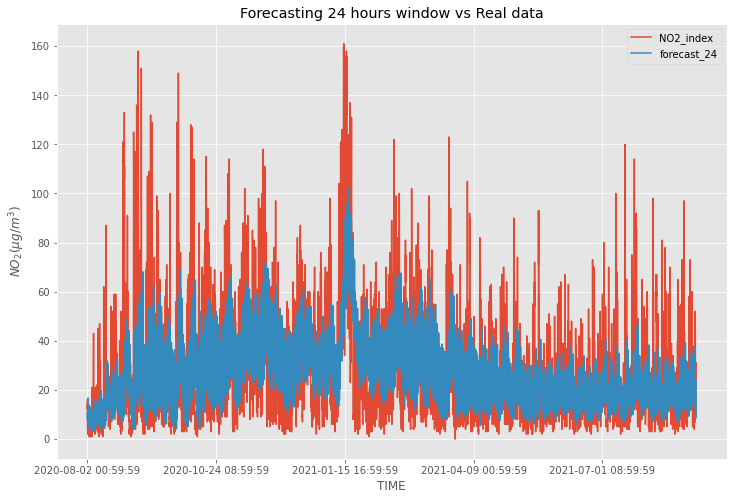

In [34]:
#Plotting 24-12-6-2 hours prediction window vs real data
################################################

data[['NO2_index', 'forecast_24']].plot(figsize=(12, 8))

plt.ylabel("$NO_2 (µg/m^3)$", fontsize=12)
plt.title("Forecasting 24 hours window vs Real data");

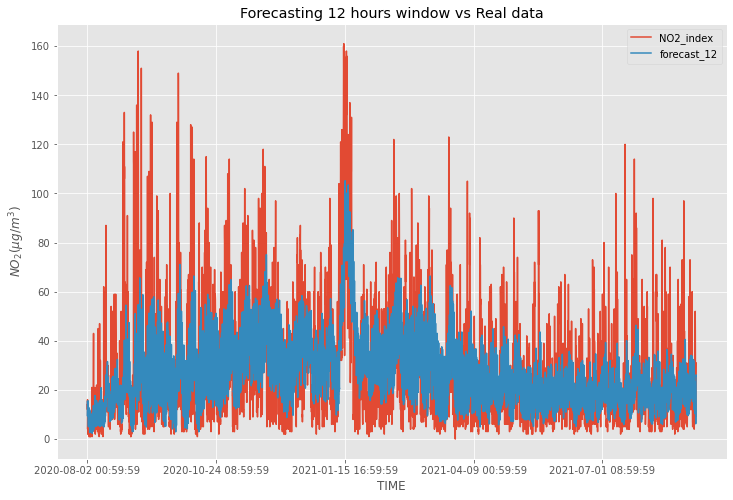

In [24]:
#Plotting 24-12-6-2 hours prediction window vs real data
################################################

data[['NO2_index', 'forecast_12']].plot(figsize=(12, 8))

plt.ylabel("$NO_2 (µg/m^3)$", fontsize=12)
plt.title("Forecasting 12 hours window vs Real data");

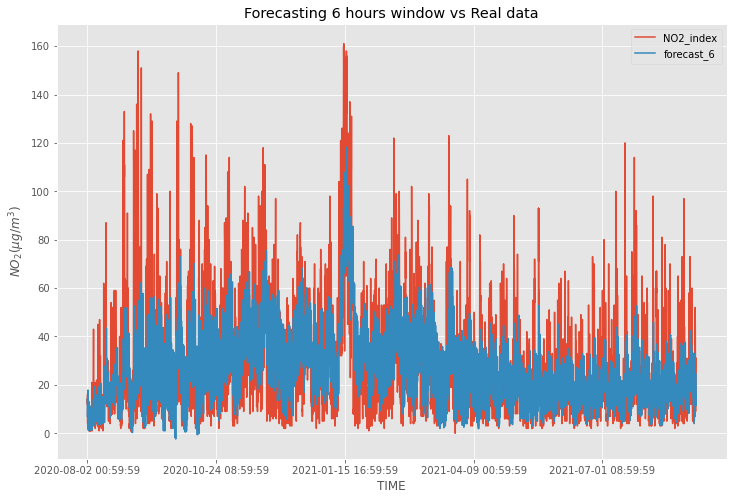

In [25]:
#Plotting 24-12-6-2 hours prediction window vs real data
################################################

data[['NO2_index', 'forecast_6']].plot(figsize=(12, 8))

plt.ylabel("$NO_2 (µg/m^3)$", fontsize=12)
plt.title("Forecasting 6 hours window vs Real data");

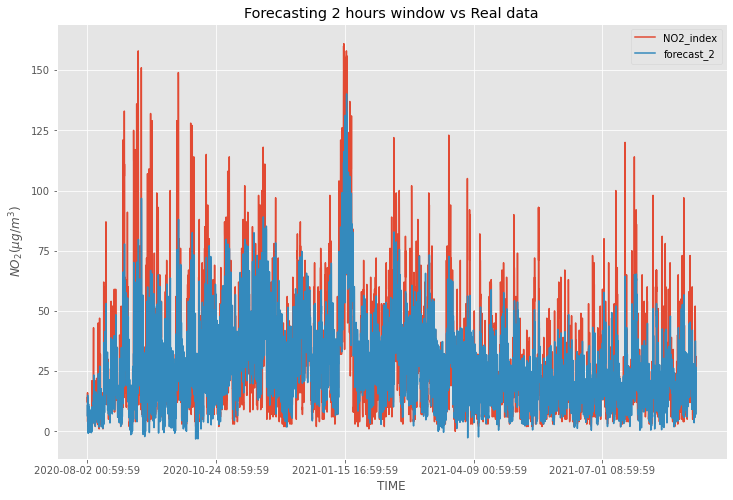

In [26]:
#Plotting 24-12-6-2 hours prediction window vs real data
################################################

data[['NO2_index', 'forecast_2']].plot(figsize=(12, 8))

plt.ylabel("$NO_2 (µg/m^3)$", fontsize=12)
plt.title("Forecasting 2 hours window vs Real data");